# Topic Modeling (LDA)

## Importo paquetes


In [6]:
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from spacy.lang.es.stop_words import STOP_WORDS
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.lda_model

# creo una lista con las stopwords en español
spanish_stop_words = list(STOP_WORDS)

/home/kevin/MEGA/text_mining/text-mining/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Cargo base de datos

In [7]:
dataset = load_dataset("mrm8488/CHISTES_spanish_jokes")
dataset['train'][0]

#convierto a pandas conservando el nombre de las columnas
df = pd.DataFrame(dataset['train'])

In [3]:
df

,id,text,keywords,funny,category
0,0,"- ¡Rápido, necesitamos sangre!\n- Yo soy 0 pos...",sangre,1,otros
1,1,- ¿Cuál es el mejor portero del mundial? \n- E...,"futbol,porteros",1,otros
2,2,El otro día unas chicas llamarón a mi puerta y...,"dinero,agua",1,otros
3,3,"- Andresito, ¿qué planeta va después de Marte?...",planetas,1,profesiones
4,4,- ¿Por qué Bob Esponja no va al gimnasio? \n- ...,"esponja,gimnasios",1,otros
...,...,...,...,...,...
2414,2414,Una mujer en la consulta del médico.\n-Hola do...,"doctor,ropa",2,profesiones
2415,2415,Error 0094782: No se detecta ningún teclado pu...,"windows,teclado",2,tematicos
2416,2416,Una chica entra a una iglesia con un buen esco...,"escote,pecho,cura",2,tematicos
2417,2417,Un hombre va a hablar con su jefe:\n-Hola veng...,"boda,jefe",2,familia


## Analisis de la base de datos

In [4]:
# cuantas categorias hay
df['category'].value_counts()

category
otros          770
familia        580
sexo           353
animales       229
profesiones    199
regionales     194
tematicos       94
Name: count, dtype: int64

In [5]:
df['category'].value_counts()/df.shape[0]
# ver como se distribuyen las categorias (topicos)
# una vez consolidados los topicos
# hacer fine turing con todos los chistes
# y luego entrenando especificamente con cada topico
# usar modelo llama cuantizado de 4bits

category
otros          0.318313
familia        0.239768
sexo           0.145928
animales       0.094667
profesiones    0.082265
regionales     0.080198
tematicos      0.038859
Name: count, dtype: float64

Así tenemos 7 categorías, siendo la más común 'otros' con un 31,8%. Exploremos también el tamaño de los chistes.

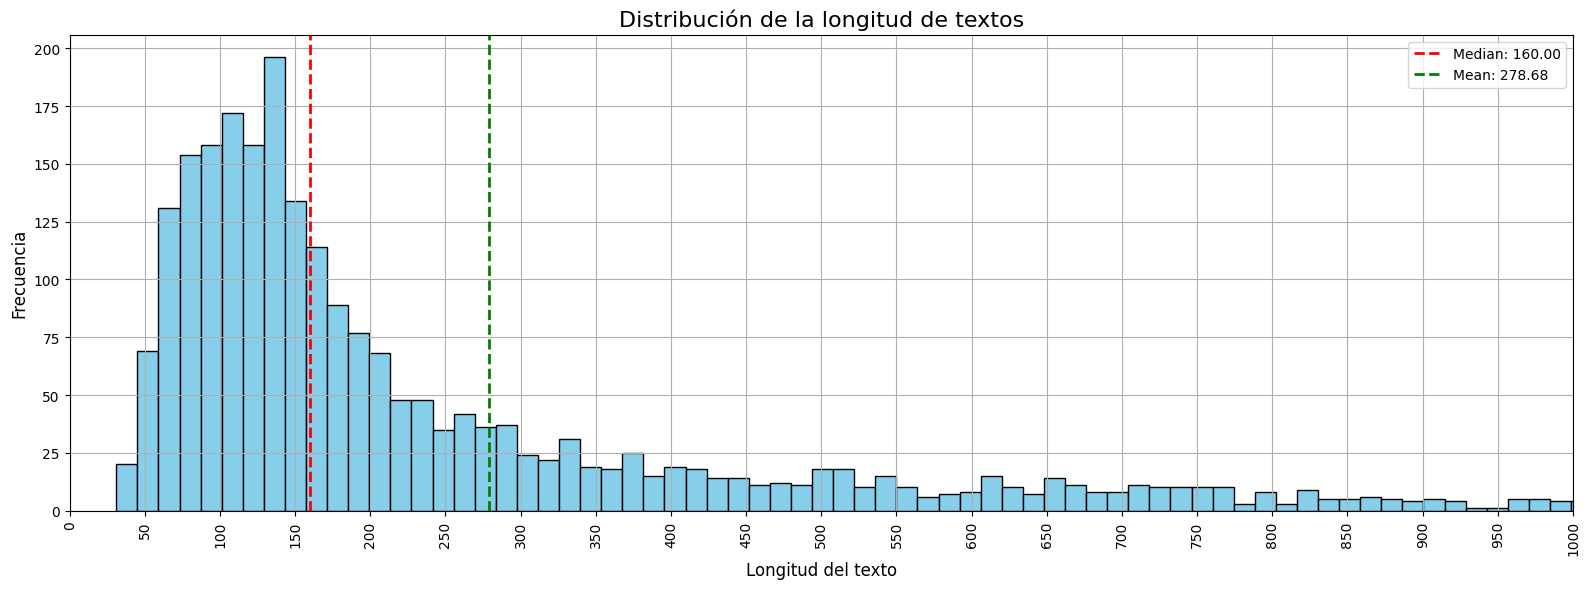

In [6]:
# Crear la columna 'len' (asegúrate de que este paso se ejecute primero)
df['len'] = df['text'].apply(lambda t: len(t))

# Ahora, puedes proceder a graficar
plt.figure(figsize=(16, 6))

# Histograma
df['len'].hist(bins=200, color='skyblue', edgecolor='black')
plt.xticks(range(0, 2000, 50), rotation=90)
plt.xlim((0, 1000))

# Líneas de la mediana y la media
median_value = df['len'].median()
mean_value = df['len'].mean()
plt.axvline(median_value, color='r', linestyle='dashed',
            linewidth=2, label=f'Median: {median_value:.2f}')
plt.axvline(mean_value, color='g', linestyle='dashed',
            linewidth=2, label=f'Mean: {mean_value:.2f}')

# Etiquetas y título
plt.title('Distribución de la longitud de textos', fontsize=16)
plt.xlabel('Longitud del texto', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()

La mitad de los chistes tienen un tamaño inferior a 160 caracteres

In [7]:
df['Palabras por chiste'] = df['text'].str.split().apply(len)
df['Palabras por chiste'].median()

31.0

Aquí podemos observar que la mediana de longitud en terminos de palabras es de 31. Esto es esperado, pues los chistes deben ser cortos por naturaleza. Por otra parte, es bastante claro que el corpus original del modelo pre-entrenado contenía texto muy diferente a este, por lo que la calidad de los resultados, sin hacer mayores modificaciones puede que no sea buena

# Modelo de clustering


In [8]:
# Preprocesamiento del texto (ejemplo simplificado)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text'])

# Aplicar K-means
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

# Obtener los clusters
df['cluster'] = kmeans.labels_

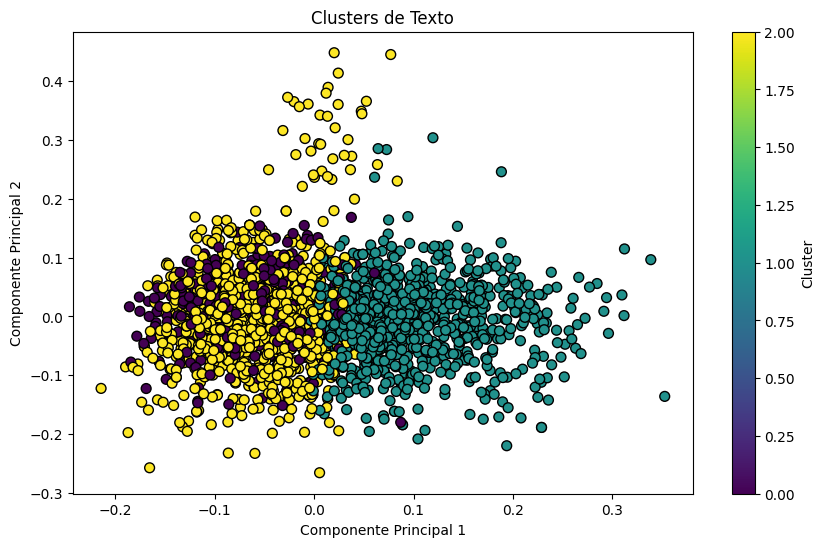

In [9]:
# Suponiendo que ya tienes df con los clusters
# Reducir la dimensionalidad
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X.toarray())

# Agregar las coordenadas reducidas al DataFrame
df['x'] = X_reduced[:, 0]
df['y'] = X_reduced[:, 1]

# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(df['x'], df['y'], c=df['cluster'],
            cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Clusters de Texto')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()

In [10]:
# veo palabras de cada clusters
# Obtener el vocabulario
words = vectorizer.get_feature_names_out()

# Crear un DataFrame para almacenar las palabras más importantes
important_words = {}

# Iterar sobre cada cluster
for cluster in range(kmeans.n_clusters):
    # Sumar los vectores TF-IDF de los documentos en este cluster
    cluster_docs = X[df['cluster'] == cluster]
    cluster_mean = np.mean(cluster_docs.toarray(), axis=0)

    # Obtener las palabras con el mayor valor en el vector promedio
    # 10 palabras más importantes
    top_indices = cluster_mean.argsort()[-10:][::-1]
    important_words[cluster] = [(words[i], cluster_mean[i])
                                for i in top_indices]

# Mostrar las palabras más importantes de cada cluster
for cluster, words in important_words.items():
    print(f'Cluster {cluster}:')
    for word, score in words:
        print(f'  {word}: {score:.4f}')

Cluster 0:
  qué: 0.1148
  por: 0.0490
  un: 0.0444
  en: 0.0394
  de: 0.0374
  los: 0.0365
  que: 0.0314
  porque: 0.0307
  la: 0.0299
  no: 0.0295
Cluster 1:
  el: 0.0984
  la: 0.0849
  que: 0.0806
  de: 0.0774
  le: 0.0729
  un: 0.0639
  en: 0.0538
  se: 0.0531
  dice: 0.0449
  al: 0.0439
Cluster 2:
  que: 0.0437
  de: 0.0423
  no: 0.0379
  la: 0.0374
  el: 0.0347
  me: 0.0303
  se: 0.0301
  un: 0.0300
  es: 0.0289
  una: 0.0261


son stops word, por lo que no aportan información relevante para el modelo. Por lo tanto, se procede a eliminarlas.

In [11]:
def preprocess_text(text):
    # Aquí puedes agregar más pasos de limpieza si es necesario
    text = text.lower()  # Convertir a minúsculas
    # ... (eliminar puntuación, etc.)
    return text


df['cleaned_text'] = df['text'].apply(preprocess_text)

# Usar TfidfVectorizer con stop words en español
vectorizer = TfidfVectorizer(stop_words=spanish_stop_words)
X = vectorizer.fit_transform(df['cleaned_text'])

# Aplicar K-means
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

# Obtener los clusters
df['cluster'] = kmeans.labels_

# (Opcional) Mostrar los clusters
print(df[['text', 'cluster']])

                                                   text  cluster
0     - ¡Rápido, necesitamos sangre!\n- Yo soy 0 pos...        2
1     - ¿Cuál es el mejor portero del mundial? \n- E...        2
2     El otro día unas chicas llamarón a mi puerta y...        2
3     - Andresito, ¿qué planeta va después de Marte?...        2
4     - ¿Por qué Bob Esponja no va al gimnasio? \n- ...        2
...                                                 ...      ...
2414  Una mujer en la consulta del médico.\n-Hola do...        2
2415  Error 0094782: No se detecta ningún teclado pu...        2
2416  Una chica entra a una iglesia con un buen esco...        1
2417  Un hombre va a hablar con su jefe:\n-Hola veng...        1
2418  Llega una pareja a un restaurante el señor muy...        1

[2419 rows x 2 columns]


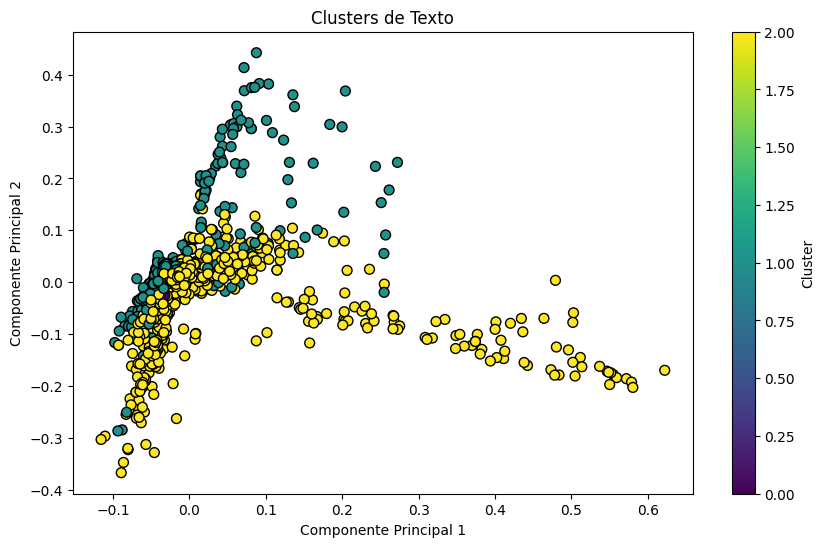

                                                   text  cluster
0     - ¡Rápido, necesitamos sangre!\n- Yo soy 0 pos...        2
1     - ¿Cuál es el mejor portero del mundial? \n- E...        2
2     El otro día unas chicas llamarón a mi puerta y...        2
3     - Andresito, ¿qué planeta va después de Marte?...        2
4     - ¿Por qué Bob Esponja no va al gimnasio? \n- ...        2
...                                                 ...      ...
2414  Una mujer en la consulta del médico.\n-Hola do...        2
2415  Error 0094782: No se detecta ningún teclado pu...        2
2416  Una chica entra a una iglesia con un buen esco...        1
2417  Un hombre va a hablar con su jefe:\n-Hola veng...        1
2418  Llega una pareja a un restaurante el señor muy...        1

[2419 rows x 2 columns]


In [12]:
def preprocess_text(text):
    # Aquí puedes agregar más pasos de limpieza si es necesario
    text = text.lower()  # Convertir a minúsculas
    # ... (eliminar puntuación, etc.)
    return text


df['cleaned_text'] = df['text'].apply(preprocess_text)

# Usar TfidfVectorizer con stop words en español
vectorizer = TfidfVectorizer(stop_words=spanish_stop_words)
X = vectorizer.fit_transform(df['cleaned_text'])

# Aplicar K-means
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

# Obtener los clusters
df['cluster'] = kmeans.labels_

# Reducir la dimensionalidad a 2D para la visualización
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X.toarray())

# Agregar las coordenadas reducidas al DataFrame
df['x'] = X_reduced[:, 0]
df['y'] = X_reduced[:, 1]

# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(df['x'], df['y'], c=df['cluster'],
            cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Clusters de Texto')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()

# (Opcional) Mostrar los clusters
print(df[['text', 'cluster']])
## visualizar (ver psa)

In [13]:
# Imprimir las palabras más importantes de cada cluster
words = vectorizer.get_feature_names_out()
for cluster in range(kmeans.n_clusters):
    # Sumar los vectores TF-IDF de los documentos en este cluster
    cluster_docs = X[df['cluster'] == cluster]
    cluster_mean = np.mean(cluster_docs.toarray(), axis=0)

    # Obtener las palabras con el mayor valor en el vector promedio
    # 10 palabras más importantes
    top_indices = cluster_mean.argsort()[-10:][::-1]
    print(f'Cluster {cluster}:')
    for i in top_indices:
        print(f'  {words[i]}: {cluster_mean[i]:.4f}')

Cluster 0:
  jardinero: 0.4107
  podamos: 0.2350
  disfrutemos: 0.2055
  dejen: 0.1096
  plantado: 0.1096
  ahorraríamos: 0.0932
  supieses: 0.0932
  dineral: 0.0932
  colmo: 0.0807
  muela: 0.0773
Cluster 1:
  hombre: 0.0744
  jaimito: 0.0445
  pregunta: 0.0399
  señor: 0.0359
  telón: 0.0233
  entra: 0.0197
  camarero: 0.0197
  responde: 0.0177
  padre: 0.0176
  mujer: 0.0174
Cluster 2:
  mamá: 0.0172
  mujer: 0.0169
  doctor: 0.0146
  hijo: 0.0134
  marido: 0.0120
  casa: 0.0086
  años: 0.0082
  tienes: 0.0081
  amor: 0.0080
  oye: 0.0076


Mejor resultado, pero un poco confuzo todavia.

# Modelo 1

Un modelo de temas con NMF (Non-negative Matrix Factorization) es una técnica que se utiliza para encontrar temas ocultos en un conjunto de documentos.

¿Cómo funciona en palabras simples?
1. Descomposición de la matriz:
    - Piensa que cada documento es como una bolsa de palabras. El modelo toma todos estos documentos y las palabras que contienen y crea una gran tabla (matriz) donde cada fila es un documento y cada columna es una palabra.
    - Luego, el modelo NMF descompone esta tabla en dos partes más pequeñas:
        - Una parte que nos dice qué palabras están relacionadas con cada tema.
        - Otra parte que nos dice qué temas están presentes en cada documento.
2. Temas ocultos:
    - El modelo NMF encuentra grupos de palabras que tienden a aparecer juntas en los documentos. Cada grupo de palabras representa un tema.
    - Por ejemplo, en un conjunto de noticias, el modelo podría identificar temas como "deportes" con palabras como "equipo", "partido", "jugador", y otro tema sobre "economía" con palabras como "mercado", "dinero", "finanzas".
3. Asignación de temas:
    - Una vez que el modelo ha encontrado los temas, puede decirte qué temas son los más importantes en cada documento. Por ejemplo, puede indicar que un documento trata en un 70% de "deportes" y en un 30% de "economía".


In [14]:
def display_topics(H, feature_names, no_top_words):
    '''
    Display the topics generated by the NMF model (without documents)
    '''
    for topic_idx, topic in enumerate(H):
        print(' ')
        print('Topic %d:' % (topic_idx))
        print(' '.join([(feature_names[i] + ' (' + str(topic[i].round(2)) + ')')
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [19]:
# Defino argumentos
no_topics = 8
no_top_words = 6

# Inicializacion del vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=spanish_stop_words)

# Ajuste y transformación del vectorizador TF-IDF
tfidf = tfidf_vectorizer.fit_transform(df['text'])

# Obtención de los nombres de las características (palabras):
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Ejecución del modelo NMF:
nmf_model = NMF(n_components=no_topics, random_state=1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Obtención de las matrices de temas y documentos
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_

print('NMF Topics')
display_topics(nmf_H, tfidf_feature_names, no_top_words)
print('--------------')

NMF Topics
 
Topic 0:
mujer (1.95) marido (1.15) amor (0.52) casa (0.52) cariño (0.46) esposa (0.32)
 
Topic 1:
mamá (1.85) escuela (0.16) colegio (0.13) hijo (0.13) mañana (0.11) tienes (0.11)
 
Topic 2:
doctor (1.96) médico (0.28) grave (0.17) operación (0.14) duele (0.14) consulta (0.14)
 
Topic 3:
jaimito (1.85) mama (0.41) maestra (0.32) profesora (0.29) clase (0.26) pregunta (0.23)
 
Topic 4:
telón (1.25) abre (0.73) película (0.69) llama (0.58) cierra (0.45) aparece (0.35)
 
Topic 5:
hijo (1.0) papá (0.85) padre (0.83) niño (0.26) papa (0.23) madre (0.22)
 
Topic 6:
hombre (1.45) perro (0.15) dios (0.14) chiste (0.1) entra (0.1) bar (0.09)
 
Topic 7:
señor (0.67) pregunta (0.43) borracho (0.33) camarero (0.33) contesta (0.31) señora (0.3)
--------------


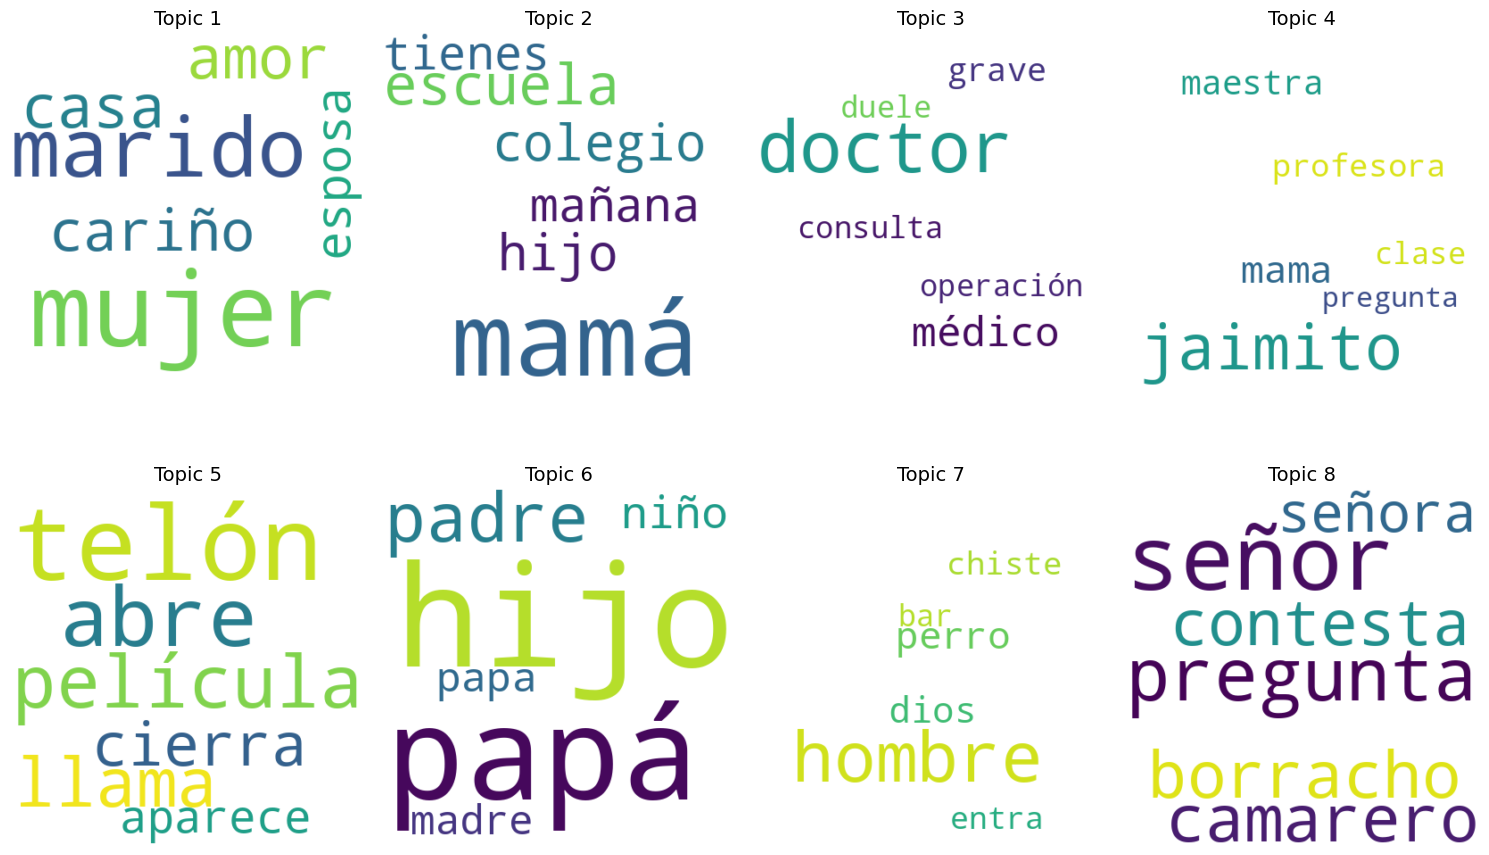

In [20]:
def plot_wordclouds(H, feature_names, no_top_words, no_topics):
    '''
    Generate word clouds for each topic
    '''
    fig, axes = plt.subplots(2, int(np.ceil(no_topics / 2)), figsize=(15, 10))
    axes = axes.flatten()

    for topic_idx, topic in enumerate(H):
        # Obtener las palabras principales y sus pesos
        top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        # Crear un diccionario de palabras y pesos
        word_freq = {top_features[i]: weights[i]
                     for i in range(len(top_features))}

        # Generar la nube de palabras
        wordcloud = WordCloud(
            width=400, height=400, background_color='white').generate_from_frequencies(word_freq)

        # Mostrar la nube en el subplot correspondiente
        axes[topic_idx].imshow(wordcloud, interpolation='bilinear')
        axes[topic_idx].axis('off')
        axes[topic_idx].set_title(f'Topic {topic_idx + 1}', fontsize=14)

    plt.tight_layout()
    plt.show()


# Graficar nubes de palabras para los tópicos
plot_wordclouds(nmf_H, tfidf_feature_names, no_top_words, no_topics)

# Modelo 2

Echando un segundo vistazo a las categorías proporcionadas, parece que no son realmente buenas (especialmente si miramos "otros").

Existen varias técnicas no supervisadas para, dada una colección de documentos, encontrar grupos de temas.

Probaremos aquí `LaternDirichletAllocation`, o LDA, que es una tecnología clásica pero generalmente es difícil trabajar con ella, ya que necesita muchos ajustes. Por ejemplo, elegir el número de temas.

In [21]:
# Usar CountVectorizer en lugar de TfidfVectorizer
count_vectorizer = CountVectorizer(stop_words=spanish_stop_words)

# Transformar los datos textuales
X_counts = count_vectorizer.fit_transform(df['text'])

# Crear el modelo LDA
number_of_topics = 8
lda = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

# Ajustar el modelo a los datos
lda.fit(X_counts)

# Preparar la visualización de los tópicos con pyLDAvis
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(
    lda, X_counts, count_vectorizer, mds='tsne', R=6)

# Mostrar la visualización interactiva
pyLDAvis.display(panel)

In [16]:
# Cargar el modelo de español de spaCy
nlp = spacy.load("es_core_news_sm")

# Función para preprocesar el texto
def preprocess_text(text):
    # Procesar el texto con spaCy
    doc = nlp(text.lower())  # Convertir a minúsculas
    # Lematizar y eliminar puntuaciones
    cleaned_text = " ".join(
        [token.lemma_ for token in doc if not token.is_punct and not token.is_space])
    return cleaned_text


# Aplicar el preprocesamiento a la columna 'text' de tu DataFrame
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Crear la lista de stop words en español
spanish_stop_words = list(STOP_WORDS)

# Preprocesamiento de los datos
count_vectorizer = CountVectorizer(
    stop_words=spanish_stop_words,
    min_df=5,
    max_df=0.8,
    ngram_range=(1, 2)  # Captura unigramas y bigramas
)

# Transformar los datos textuales
X_counts = count_vectorizer.fit_transform(df['cleaned_text'])

# Crear el modelo LDA
number_of_topics = 8
lda = LatentDirichletAllocation(
    n_components=number_of_topics,
    random_state=0,
    learning_method='online',
    max_iter=100,  # Incrementar iteraciones
)

# Ajustar el modelo a los datos
lda.fit(X_counts)

# Preparar la visualización de los tópicos con pyLDAvis
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(
    lda, X_counts, count_vectorizer, mds='tsne', R=6)

# Mostrar la visualización interactiva
pyLDAvis.display(panel)

Burbuja:
- Cuanto mas grande la burbuja, mas frecuente es el tema en los documentos.
- Un modelo de tema con un número bajo de temas tendrá grandes burbujas no superpuestas, dispersas en todo el gráfico, mientras que el modelo de tema con un alto número de temas, tendrá muchas burbujas superpuestas de tamaño pequeño, agrupadas en el gráfico.
- La distancia entre los temas es una aproximación de la relación semántica entre los temas

Grafico horizontal:
- El gráfico de barras muestra la distribución de frecuencia de las palabras en los documentos (color: azul).
- El área sombreada roja describe la frecuencia de cada palabra dada un tema.
- Al seleccionar un tema (haciendo clic en una burbuja de tema), se muestran las 10 palabras principales (con el área de sombra roja).
- Pasando el cursor sobre las palabras específicas (en el panel derecho), solo el tema que contiene las palabras es visible. El tamaño de la burbuja en este escenario describe la edad de peso de la palabra sobre ese tema. Cuanto mayor sea el peso de la palabra seleccionada, mayor será el tamaño de la burbuja.

Disminución del parámetro lambda, aumentar el peso de la relación de la frecuencia de la palabra dado el tema /Frecuencia general de la palabra en los documentos.Palabras importantes para el tema dado se mueve hacia arriba.